# Procesamiento y Análisis de Señales ECG

Este notebook implementa técnicas avanzadas para el procesamiento de señales electrocardiográficas (ECG/EKG), incluyendo:
- Generación de señales ECG sintéticas
- Detección de complejos QRS y picos R
- Detección de ondas P
- Análisis de intervalos RR y frecuencia cardíaca
- Procesamiento de señales ECG reales para detección de arritmias

## 1. Instalación de Dependencias

Primero instalamos las librerías necesarias para el procesamiento de señales.

In [1]:
# !pip install pywavelets neurokit2 numpy scipy matplotlib pandas seaborn tqdm

## 2. Importación de Librerías

Importamos todas las librerías necesarias para el análisis de señales ECG:
- **neurokit2**: Librería especializada en procesamiento de señales fisiológicas
- **numpy**: Operaciones numéricas y matrices
- **scipy.signal**: Procesamiento de señales digitales
- **matplotlib**: Visualización de datos
- **pywt**: Transformada wavelet para análisis tiempo-frecuencia

In [2]:
import neurokit2 as nk
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.signal import butter, filtfilt, find_peaks, hilbert, peak_widths
import pywt

### 3.1 Funciones Auxiliares

Definimos funciones para suavizado y refinamiento de picos detectados.

In [3]:
def moving_average(x, w):
    w = max(1, int(w))
    c = np.ones(w) / w
    return np.convolve(x, c, mode='same')


In [4]:
def butter_bandpass(low, high, fs, order=3):
    nyq = 0.5*fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return b, a

def bandpass(x, fs, low=0.5, high=15.0, order=3):
    b, a = butter_bandpass(low, high, fs, order)
    return filtfilt(b, a, x)

def robust_thr(x, k=2.2):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med + k*mad

def enhance_p_band(ecg, fs):
    """
    Bandpass (0.5–15 Hz) to suppress drift & HF noise, then
    wavelet detail reconstruction in ~4–12 Hz and amplitude envelope.
    """
    x = bandpass(ecg, fs, 0.5, 15.0, order=3)

    # Choose a wavelet level whose pseudo-band covers ~4–12 Hz.
    # Heuristic: level ≈ round(log2(fs/24)) bounded to [2,5]
    level = int(np.clip(np.rint(np.log2(fs/24.0)), 2, 5))
    coeffs = pywt.wavedec(x, 'db6', level=level)

    # Keep only one detail level near the P band
    keep = [np.zeros_like(c) for c in coeffs]
    target_detail = len(coeffs) - level  # detail index to keep
    keep[target_detail] = coeffs[target_detail]
    x_p = pywt.waverec(keep, 'db6')
    x_p = x_p[:len(x)]

    # Envelope of the enhanced signal (smooth energy)
    env = np.abs(hilbert(x_p))
    # Light smoothing (~30 ms) to stabilize envelope
    w = max(1, int(0.03*fs))
    env = np.convolve(env, np.ones(w)/w, mode='same')
    return x, x_p, env

def bandpass_filter(ecg, fs, low=5, high=15, order=3):
    nyq = fs/2
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, ecg)

def lowpass_filter(ecg, fs, cutoff=12, order=4):
    nyq = fs/2
    b, a = butter(order, cutoff/nyq, btype="low")
    return filtfilt(b, a, ecg)

### 3.2. Detección de Onda P con Neurokit2

Usamos la librería Neurokit2 que implementa algoritmos validados para detección de ondas P.

In [5]:
def detect_pwaves_neurokit(ecg, fs):
    """
    Detecta ondas P usando neurokit2.
    
    Retorna:
    - p_peaks: índices de las ondas P
    - p_signal: la señal procesada de neurokit2 (útil para debug)
    """
    # Procesamiento completo del ECG
    signals, info = nk.ecg_process(ecg, sampling_rate=fs)
    
    # P-peaks detectados por neurokit2
    p_peaks = info["ECG_P_Peaks"]
    
    # Quitar NaNs
    p_peaks = p_peaks[~np.isnan(p_peaks)].astype(int)
    
    # Señal de onda P (opcional, útil para gráficos)
    p_signal = signals["ECG_P"]
    
    return p_peaks, p_signal


### 3.2. Detección de QRS con Neurokit2


In [6]:
def pan_tompkins_qrs(ecg, fs):
    """
    Implementación clásica Pan–Tompkins:
    - bandpass 5–15 Hz
    - derivada
    - cuadrado
    - ventana móvil 150 ms
    - umbral adaptativo robusto
    """
    # 1) Bandpass para QRS
    x = bandpass(ecg, fs, low=5, high=15)

    # 2) Derivada
    dx = np.diff(x, prepend=x[0])

    # 3) Cuadrado
    sq = dx**2

    # 4) Ventana móvil 150 ms
    win = int(0.15 * fs)
    mwa = np.convolve(sq, np.ones(win)/win, mode="same")

    # 5) Umbral robusto
    thr = np.median(mwa) + 3*np.std(mwa)

    # 6) R-peaks preliminares
    refractory = int(0.25 * fs)
    r_peaks, _ = find_peaks(mwa, height=thr, distance=refractory)

    return r_peaks, mwa

In [7]:
def detect_qs(ecg, fs, r_peaks):
    q_peaks = []
    s_peaks = []

    for r in r_peaks:
        left = max(0, r - int(0.04 * fs))
        right = min(len(ecg), r + int(0.04 * fs))

        # Q = mínimo antes del R
        q_seg = ecg[left:r]
        q_peaks.append(left + np.argmin(q_seg) if len(q_seg) > 0 else np.nan)

        # S = mínimo después del R
        s_seg = ecg[r:right]
        s_peaks.append(r + np.argmin(s_seg) if len(s_seg) > 0 else np.nan)

    return np.array(q_peaks), np.array(s_peaks)


In [8]:
def detect_qrs_complex(ecg, fs):
    """
    Devuelve r_peaks, q_peaks, s_peaks
    Ahora los R vienen de Pan–Tompkins para mejor estabilidad.
    """

    # --------------------------------
    # 1. Usar Pan–Tompkins clásico
    # --------------------------------
    r_peaks, qrs_env = pan_tompkins_qrs(ecg, fs)

    # --------------------------------
    # 2. Detectar Q y S
    # --------------------------------
    q_peaks, s_peaks = detect_qs(ecg, fs, r_peaks)

    return r_peaks, q_peaks, s_peaks, qrs_env


In [9]:
def detect_twaves_only(ecg, fs, r_peaks):

    t_band = bandpass_filter(ecg, fs, low=1, high=7)

    env = np.abs(hilbert(t_band))
    env_lp = lowpass_filter(env, fs, cutoff=8)

    # Umbral más sensible
    thr = np.median(env_lp) + 0.4*np.std(env_lp)

    cand, _ = find_peaks(env_lp, height=thr, distance=int(0.25*fs))

    t_peaks = []

    for t in cand:
        for r in r_peaks:
            # ventana fisiológica ampliada
            if int(0.08*fs) < (t - r) < int(0.45*fs):
                t_peaks.append(t)

    return np.array(t_peaks, dtype=int), env_lp


---

## 4. Análisis de Señales ECG Reales.

En esta sección analizamos señales ECG reales de la base de datos ECG signals (1000 fragments) 
https://data.mendeley.com/datasets/7dybx7wyfn/3

### 4.1 Carga de Datos Reales

In [10]:
import pickle
!dir
path_db = "ECG_DATASET/dataset_ekg.pkl"

with open(path_db, "rb") as f:
    dataset = pickle.load(f)

dataset

zsh:1: command not found: dir


{'NSR': array([[-0.06451476, -0.05951476, -0.02951476, ...,  0.13548524,
          0.13048524,  0.11548524],
        [ 0.24548524,  0.25048524,  0.24048524, ...,  0.34048524,
          0.33548524,  0.31548524],
        [ 0.13048524,  0.12548524,  0.11048524, ..., -0.20451476,
         -0.20451476, -0.20451476],
        ...,
        [-0.46451476, -0.46451476, -0.46451476, ..., -0.59451476,
         -0.58951476, -0.58951476],
        [-0.53451476, -0.51451476, -0.53451476, ..., -0.51451476,
         -0.44451476, -0.40451476],
        [ 0.51548524,  0.50548524,  0.50548524, ...,  0.21048524,
          0.20048524,  0.18548524]]),
 'VT': array([[ 0.10787069,  0.08787069,  0.08787069, ...,  0.01287069,
         -0.00212931,  0.01787069],
        [-0.31212931, -0.29712931, -0.27212931, ...,  0.82787069,
          0.84787069,  0.86787069],
        [ 0.01287069,  0.00787069,  0.00287069, ...,  0.04787069,
          0.06787069,  0.10287069],
        ...,
        [ 0.17287069,  0.16787069,  0.162

In [11]:
dataset.keys()

dict_keys(['NSR', 'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW', 'PVC', 'Bigeminy', 'Trigeminy'])

### 4.2 Selección de Señal para Análisis

Seleccionamos una señal de Trigeminia (tipo de arritmia ventricular) para analizar.

In [12]:
ecg_signal = dataset["Trigeminy"][0,:]
ecg_signal

array([0.21956848, 0.22456848, 0.21956848, ..., 0.19956848, 0.18956848,
       0.19456848])

In [13]:
ecg_signal.shape

(3600,)

### 4.3 Visualización de la Señal Real

Graficamos la señal ECG real para observar su morfología y características.

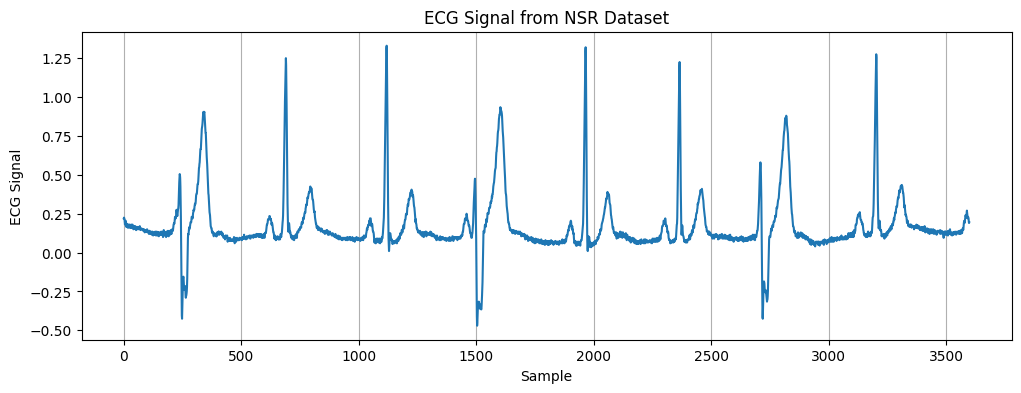

In [14]:
# Detección de la onda P usando neurokit2
fs = 360
t = np.arange(ecg_signal.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(ecg_signal)
plt.xlabel("Sample")
plt.ylabel("ECG Signal")
plt.title("ECG Signal from NSR Dataset")
plt.grid(axis='x')

### 4.4 Detección de Ondas P en Señal Real

Aplicamos el detector de ondas P de Neurokit2 a la señal real y visualizamos los resultados. La detección correcta de ondas P es crucial para identificar arritmias auriculares.

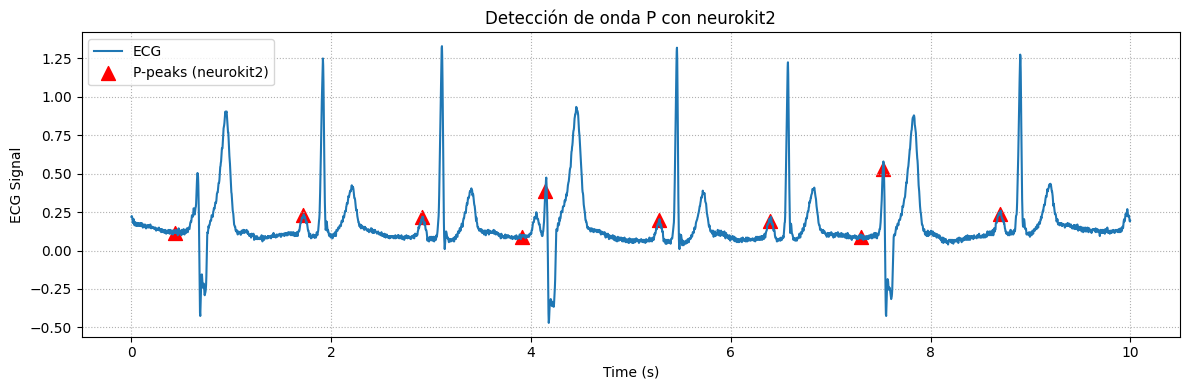

In [15]:
# Detección de la onda P usando neurokit2
signals, info_nk = nk.ecg_process(ecg_signal, sampling_rate=fs)
p_peaks_nk = info_nk["ECG_P_Peaks"]

# Graficar ECG y detecciones de onda P
plt.figure(figsize=(12, 4))
plt.plot(t, ecg_signal, label="ECG")
plt.scatter(t[p_peaks_nk], ecg_signal[p_peaks_nk], color='red', marker='^', s=100, label="P-peaks (neurokit2)")
plt.xlabel("Time (s)")
plt.ylabel("ECG Signal")
plt.title("Detección de onda P con neurokit2")
plt.legend()
plt.grid(ls=":")
plt.tight_layout()
plt.show()

### 4.4 Detección de Ondas QRS en Señal Real

Este bloque aplica el algoritmo Pan–Tompkins para identificar los picos R y, a partir de ellos, localizar los puntos Q y S.

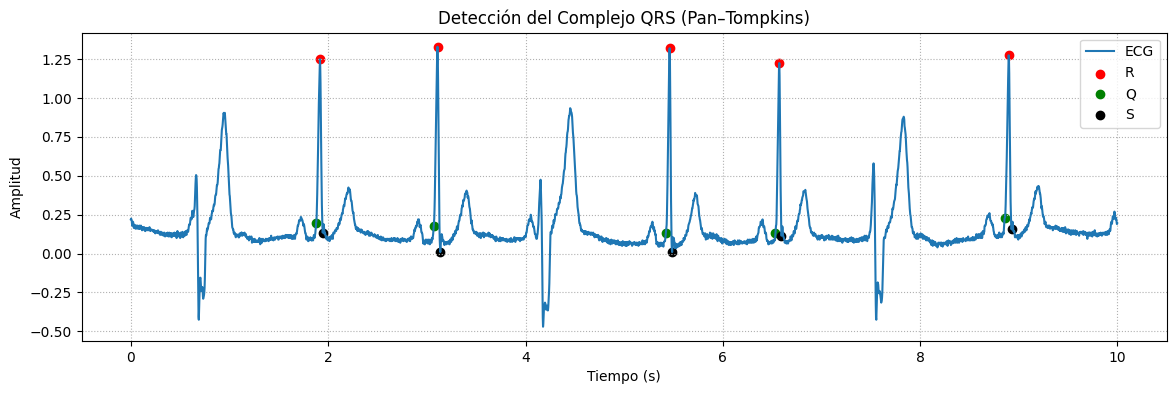

In [16]:
# ---- QRS ----
r_peaks, q_peaks, s_peaks, qrs_env = detect_qrs_complex(ecg_signal, fs)

# ---- Graficar ----
plt.figure(figsize=(14,4))
plt.plot(t, ecg_signal, label="ECG")
plt.scatter(t[r_peaks], ecg_signal[r_peaks], color="red", label="R")
plt.scatter(t[q_peaks], ecg_signal[q_peaks], color="green", label="Q")
plt.scatter(t[s_peaks], ecg_signal[s_peaks], color="black", label="S")

plt.title("Detección del Complejo QRS (Pan–Tompkins)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(ls=":")
plt.show()



### 4.5 Detección de ondas T en Señal Real
Este bloque analiza la región después de cada R (200–500 ms) para localizar la onda T, usando suavizado y una envolvente de energía.

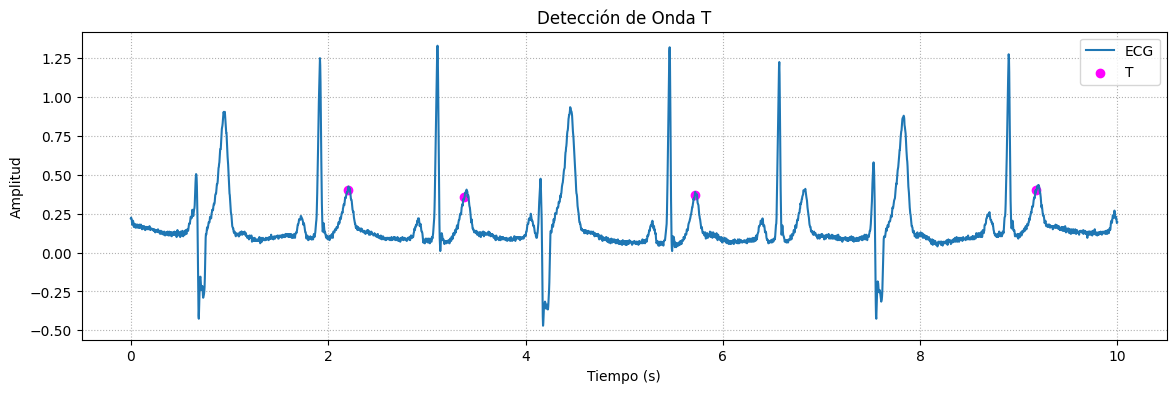

In [17]:
# ---- TWaves ----
t_peaks, t_env = detect_twaves_only(ecg_signal, fs, r_peaks)

# ---- FIX tipo entero ----
t_peaks = t_peaks.astype(int)

# ---- Graficar SOLO T ----
plt.figure(figsize=(14,4))
plt.plot(t, ecg_signal, label="ECG")
plt.scatter(t[t_peaks], ecg_signal[t_peaks], color="magenta", label="T")

plt.title("Detección de Onda T")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(ls=":")
plt.show()